In [1]:
!pip install -qU pymupdf4llm Pillow langchain langchain-openai langchain-text-splitters langchain_community langchain-pymupdf4llm langgraph gradio ipywidgets


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os

if not os.environ.get("OPENAI_API_KEY"):
    raise "OPENAI_API_KEY not set"

if not os.environ.get("LANGSMITH_API_KEY"):
    raise "LANGSMITH_API_KEY not set"
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "ai-final"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_TRACING_V2"] = "true"

PDF_FILE = "EPAM-Reports-Results-for-Fourth-Quarter-and-Full-Year-2024.pdf"

IMAGES_FOLDER = './storage/images'
TABLES_FOLDER = './storage/tables'

IMAGES_SUMMARY_MODEL = "gpt-4o-mini"
IMAGES_SUMMARY_PROMPT = "Describe the image in detail. For context, the image is part of a PDF document"

TABLES_SUMMARY_MODEL = "gpt-4o-mini"
TABLES_SUMMARY_PROMPT = "Describe the image of the table in detail. For context, the image is part of a PDF document."

LLM_MODEL = "gpt-4o"

CHUNK_SIZE = 500
CHUNK_OVERLAP = 0

EMBEDDINGS_MODEL = "text-embedding-3-small"

os.makedirs(IMAGES_FOLDER, exist_ok=True)
os.makedirs(TABLES_FOLDER, exist_ok=True)


In [3]:
import fitz
import io
from PIL import Image
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.documents import Document
import pymupdf4llm
import base64
from IPython.display import Markdown
from langchain.chat_models import init_chat_model
import IPython.display
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
import json


In [4]:
doc: fitz.Document = fitz.open(PDF_FILE)

In [5]:
def summarize_images(images: list[str], prompt_template: str, model) -> list[str]:
    messages = [
        (
            "user",
            [
                {"type": "text", "text": prompt_template},
                {
                    "type": "image_url",
                    "image_url": {"url": "data:image/png;base64,{image}"},
                },
            ],
        )
    ]

    prompt = ChatPromptTemplate.from_messages(messages)

    chain = prompt | ChatOpenAI(model=model) | StrOutputParser()
    return chain.batch(images)

In [6]:

def extract_images(doc: fitz.Document, model: str, prompt: str, summarize: bool = True) -> list[Document]:
    documents: list[Document] = []
    images: list[str] = []
    for idx, page in enumerate(doc):
        for img in page.get_images(full=True):
            xref = img[0]
            base_image = doc.extract_image(xref)["image"]
            pil_image = Image.open(io.BytesIO(base_image))
            file = f"{IMAGES_FOLDER}/{idx}_{img[7]}.png"
            pil_image.save(file, "PNG")
            documents.append(
                Document(page_content="",
                         metadata=dict(doc.metadata, pdf=doc._name, page=page.number + 1, file=file, type="image")))
            if summarize:
                images.append(base64.encodebytes(base_image).decode("ascii"))
    if summarize:
        summarized_images = summarize_images(images,
                                             prompt,
                                             model)
        for doc, summary in zip(documents, summarized_images):
            doc.page_content = summary
    return documents



In [7]:

def extract_tables(doc: fitz.Document, model: str, prompt: str, summarize: bool = True) -> list[Document]:
    documents: list[Document] = []
    images: list[str] = []
    for idx, page in enumerate(doc):
        tabs = page.find_tables()  # detect the tables
        for i, tab in enumerate(tabs):  # iterate over all tables
            pix = page.get_pixmap(clip=tab.bbox)
            file = f"{TABLES_FOLDER}/{idx}_{i}.png"
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            img.save(file, "PNG")
            buffered = io.BytesIO()
            img.save(buffered, format="PNG")
            documents.append(
                Document(page_content="",
                         metadata=dict(doc.metadata, pdf=doc._name, page=page.number + 1, file=file, type="table")))
            if summarize:
                images.append(base64.encodebytes(buffered.getvalue()).decode("ascii"))
    if summarize:
        summarized_images = summarize_images(images, prompt, model)
        for doc, summary in zip(documents, summarized_images):
            doc.page_content = summary

    return documents


In [8]:

def extract_text(doc: fitz.Document) -> list[Document]:
    pages = pymupdf4llm.to_markdown(doc=doc, ignore_images=True, table_strategy=None, page_chunks=True)
    return [Document(page_content=page['text'], metadata=dict(page['metadata'], type='text')) for page in pages]


In [9]:
def create_retriever(embeddings_model: str, chunk_size: int, chunk_overlap: int):
    embeddings = OpenAIEmbeddings(model=embeddings_model)
    store = InMemoryStore()
    return ParentDocumentRetriever(
        vectorstore=InMemoryVectorStore(embeddings),
        docstore=store,
        child_splitter=RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap),
    )


In [10]:
def create_document_info(doc: fitz.Document, text_docs, image_docs, table_docs) -> dict:
    doc_info = {}
    doc_info["name"] = doc._name
    doc_info["pages_count"] = len(doc)
    doc_info["images_count"] = len(image_docs)
    doc_info["tables_count"] = len(table_docs)
    doc_info["text_length"] = sum([len(doc.page_content) for doc in text_docs])
    for page in range(len(doc)):
        page_info = {}
        page_info["page_number"] = page + 1
        page_info["text_length"] = len(text_docs[page].page_content)
        page_info["images_count"] = len([document for document in image_docs if document.metadata["page"] == page + 1])
        page_info["tables_count"] = len([document for document in table_docs if document.metadata["page"] == page + 1])
        doc_info[f"page_{page + 1}"] = page_info
    return doc_info

In [11]:
def create_retriever_from_document(doc: fitz.Document, embeddings_model: str, chunk_size, chunk_overlap,
                                   images_summary_model, images_summary_prompt,
                                   tables_summary_model, tables_summary_prompt):
    retriever = create_retriever(embeddings_model, chunk_size, chunk_overlap)

    text_docs = extract_text(doc)
    image_docs = extract_images(doc, images_summary_model, images_summary_prompt)
    table_docs = extract_tables(doc, tables_summary_model, tables_summary_prompt)

    retriever.add_documents(text_docs)
    retriever.add_documents(image_docs)
    retriever.add_documents(table_docs)

    return retriever, create_document_info(doc, text_docs, image_docs, table_docs)


In [12]:
retriever, doc_info = create_retriever_from_document(doc, EMBEDDINGS_MODEL, CHUNK_SIZE, CHUNK_OVERLAP,
                                                     IMAGES_SUMMARY_MODEL, IMAGES_SUMMARY_PROMPT, TABLES_SUMMARY_MODEL,
                                                     TABLES_SUMMARY_PROMPT)

In [13]:
def retrieve_page_resource(page_number: int, type) -> list[Document]:
    return [document for _, document in retriever.docstore.store.items() if
            document.metadata["page"] == page_number and document.metadata["type"] == type]


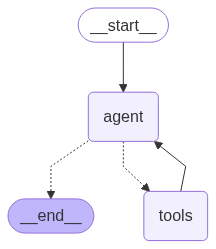

In [14]:
def serialize_docs(docs: list[Document]) -> str:
    return "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in docs
    )


@tool(response_format="content_and_artifact")
def retrieve_images_from_page(page_number: int):
    """Retrieve a detailed summary of images from a page."""
    retrieved_docs = retrieve_page_resource(page_number, "image")
    serialized = serialize_docs(retrieved_docs)
    return serialized, retrieved_docs


@tool(response_format="content_and_artifact")
def retrieve_tables_from_page(page_number: int):
    """Retrieve a detailed summary of tables from a page."""
    retrieved_docs = retrieve_page_resource(page_number, "table")
    serialized = serialize_docs(retrieved_docs)
    return serialized, retrieved_docs


@tool(response_format="content_and_artifact")
def retrieve_text_from_page(page_number: int):
    """Retrieve text content from a page."""
    retrieved_docs = retrieve_page_resource(page_number, "text")
    serialized = serialize_docs(retrieved_docs)
    return serialized, retrieved_docs


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query from the document."""
    retrieved_docs = retriever.invoke(query)
    serialized = serialize_docs(retrieved_docs)
    return serialized, retrieved_docs


def create_agent(llm_model, doc_info):
    llm = init_chat_model(llm_model, model_provider="openai")
    doc_structure = json.dumps(doc_info, indent=4)
    system_prompt = """You are a helpful assistant capable of answering questions about the user's document. Use the appropriate tools to retrieve relevant information from the user's document. If you don't know the answer, simply state that you don't know.
The document has the following structure:\n""" + doc_structure

    return create_react_agent(llm,
                              [retrieve, retrieve_images_from_page, retrieve_tables_from_page, retrieve_text_from_page],
                              prompt=system_prompt,
                              checkpointer=MemorySaver())


agent_executor = create_agent(LLM_MODEL, doc_info)
display(IPython.display.Image(agent_executor.get_graph().draw_mermaid_png()))


In [ ]:
import gradio as gr
from datetime import datetime

config = None


def recreate_config():
    global config
    config = {"thread_id": datetime.now().strftime("%H:%M:%S")}


recreate_config()


def user(user_message, history: list):
    return "", history + [{"role": "user", "content": user_message}]


def bot(history: list):
    user_msg = history[-1]["content"]

    processed_messages_count = 0
    for stem_num, step in enumerate(agent_executor.stream(
            {"messages": [{"role": "user", "content": user_msg}]},
            stream_mode="values",
            config=config,
    )):
        if stem_num == 0:
            processed_messages_count = len(step["messages"])
            for message in reversed(step["messages"]):
                if message.type != 'human':
                    processed_messages_count -= 1
                else:
                    break

        for message in step["messages"][processed_messages_count:]:
            if message.type == "ai":
                processed_messages_count += 1
                if len(message.tool_calls) > 0:
                    content = content = message.content
                    if len(content) == 0:
                        content = "I need to call some tools..."
                    history.append(gr.ChatMessage(role="assistant", content=content,
                                                  metadata={"id": message.id, "title": "🧠 Thinking"}))
                    for tool_call in message.tool_calls:
                        history.append(gr.ChatMessage(role="assistant",
                                                      content=f"I need to use the **{tool_call["name"]}** tool with arguments **{tool_call["args"]}**.",
                                                      metadata={"parent_id": message.id}))
                else:
                    history.append(gr.ChatMessage(role="assistant", content=message.content))
            elif message.type == "tool":
                processed_messages_count += 1
                history.append(gr.ChatMessage(role="assistant", content=message.content[:15] + "...",
                                              metadata={
                                                  "title": f"🛠️ Used tool **{message.name}** {message.tool_call_id}",
                                                  "id": message.id}))
                for artifact in message.artifact:
                    metadata = None
                    if type(artifact) is dict:
                        metadata = artifact["metadata"]
                    else:
                        metadata = artifact.metadata
                    if "file" in metadata:
                        history.append(
                            gr.ChatMessage(role="assistant", content=gr.Image(value=metadata["file"]),
                                           metadata={"title": metadata["file"]}))
                    else:
                        history.append(gr.ChatMessage(role="assistant", content=artifact.page_content,
                                                      metadata={"parent_id": message.id}))
            yield history

with gr.Blocks() as demo:
    chatbot = gr.Chatbot(type="messages")
    msg = gr.Textbox()

    msg.submit(user, [msg, chatbot], [msg, chatbot], queue=False).then(
        bot, chatbot, chatbot
    )
    chatbot.clear(recreate_config)

demo.launch(debug=True, height=600)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
